In [1]:
import pandas as pd
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import datetime

In [2]:
#mount drive to access data xlsx
import os 
from google.colab import drive
drive.mount('/content/drive')

#set directory
os.chdir('/content/drive/MyDrive/02 University/Masters of Data Science/MA5851 Master Class 1/Assessment 3/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python --version

In [ ]:
datascrape = pd.DataFrame(columns = ['url','hospital','datetime','comment'])

# WebCrawler
This section contains the code for section "WebCrawler" in the supporting assessment paper.

In [ ]:
#Function takes the reviewID and scrapes info from website
def get_info_from_careopinion(review):
  url = website+str(review)
  webpage = uReq(url) #connect
  #grabs the website data
  page_html = webpage.read()
  webpage.close()
  page_soup = soup(page_html, "html.parser") #parse HTML
  container = page_soup.find("div",{"class":"story_copy tm-area text-content font-c-1"})
  sentiment_sec = page_soup.find("div",{"class":"module standard_module tag-summary"})
  try:
    comment = str(container.blockquote)
    timestamp = str(page_soup.find("time",{"class":"tooltip tooltip-lg"}))
    hospital_section = page_soup.find("div",{"class":"read_story clearfix"})
    hospital = str(hospital_section.article.p.span.a)
    url = review
    sentiment = str(container.h3)
  except AttributeError:
    #where the reviewID has no relevant data
    pass
    
  return {'url':url, 
        'hospital':hospital, 
        'datetime':timestamp, 
        'comment':comment,
        'sentiment':sentiment           
        }

In [ ]:
#check if file exists and if it does, load the data to get latest ID number
#and use as starting point - only want to get the delta.
#import datascrape csv
try:
  latest_file = pd.read_csv ("/content/drive/MyDrive/02 University/Masters of Data Science/MA5851 Master Class 1/Assessment 3/datascrape.csv", on_bad_lines='skip')
  max_id = max(latest_file['url'])
except(FileNotFoundError,NameError):
  max_id = 82500 #unique ID that was -6months from date of web-scraper initial run


In [ ]:
#section calls the scraper and populates a table with metadata
website = 'https://www.careopinion.org.au/'
cnt = 0
review_start = max_id+1 #latest review from webiste, then grab next batch
review_end = review_start+99 #look for the next 100 entries
datascrape_raw = []
start_datetime = datetime.datetime.now()

#loop through using the latest ID keys to grab more data
for review in range(review_start,review_end+1):
  try:
    cnt = cnt+1
    datascrape_raw.append(get_info_from_careopinion(review))      
  except:
    pass
  print("progress:"+str(cnt)+'/'+str(len(range(review_start,review_end+1))))

datascrape_raw = pd.DataFrame(datascrape_raw)
datascrape = datascrape_raw
complete_datetime = datetime.datetime.now()
timetaken = complete_datetime - start_datetime
#print(timetaken) 5000 entries took approx 3hrs


In [ ]:
#export update as csv to capture the delta
#first see if it exists, if it doesnt, create it otherwise append
import csv
try:
  datascrape.to_csv('datascrape.csv', mode='a', index=True, header=False)

except(FileNotFoundError,NameError):
  file_header = ['url','hospital','datetime','comment','sentiment']
  datascrape.to_csv('datascrape_v2.csv',header=file_header)

In [ ]:
#import datascrape csv
try:
  datascrape = pd.read_csv("/content/drive/MyDrive/02 University/Masters of Data Science/MA5851 Master Class 1/Assessment 3/datascrape.csv", on_bad_lines='skip',encoding='cp1252')
  datascrape.reset_index(inplace=True, drop=True)
except(FileNotFoundError):
  print("File does not exist, please update filepath")


In [ ]:
#function to remove html tags from hospital column
def strip_html_tags_from_hospital(data):
  try:
    data = str(data)
    data = (data[data.find('>')+len('>'):data.rfind('</a>')])
    data = data.split(' / ')[0] #added to remve hospital sub-section
  except AttributeError:
    #where the reviewID has no relevant data
    print('error') 
  return data

#function to remove html tags from datetime column
def strip_html_tags_from_timestamp(data):
  try:
    data = str(data)
    data = (data[data.find('datetime="')+len('datetime="'):data.rfind('" item')])
    data = pd.to_datetime(data)
  except AttributeError:
    #where the reviewID has no relevant data
    print('error') 
  return data

#function to remove html tags from comment column
def strip_html_tags_from_comment(data):
  try:
    data = str(data)
    data = (data[data.find('reviewBody"')+len('reviewBody"'):data.rfind('</blockquote>')])
    data = data.replace('lang="en"','')
    data = data.replace('</p>','')
    data = data.replace('<p>','')
    data = data.replace('>\n','')
    data = data.replace('<strong>','')
    data = data.replace('</strong','')
    data = data.replace('&amp','')
    data = data.replace('\xa0','')
    data = data.replace('&lt','')
    data = data.replace('&gt','')
    data = data.replace('<br/>','')
    #this is to capture any non-standard strings that will be removed and not treated
    if data.startswith('<') == True:
      data = ''  
  except AttributeError:
    #where the reviewID has no relevant data
    print('error') 
  return data

In [ ]:
#clean data to remove HTML tags
#add label for test/train dataset
df1 = datascrape
df2 = pd.DataFrame(columns = ['url','hospital','datetime','comment'])
df2["url"] = df1['url']
df2["hospital"] = df1['hospital'].apply(lambda x: strip_html_tags_from_hospital(x))
df2["datetime"] = df1['datetime'].apply(lambda x: strip_html_tags_from_timestamp(x))
df2["comment"] = df1['comment'].apply(lambda x: strip_html_tags_from_comment(x))
#df2['sentiment'] = df1['sentiment']
df2['Sentiment_Label'] = np.where(df1['sentiment'].str.contains("good"),"1","0")

# Data Wrangling
This section contains the code for section "WebCrawler" in the supporting assessment paper.

In [ ]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words('english')

In [ ]:
#removing stop words
df2["comment"] = df2["comment"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [ ]:
 #stemming
 #Stemming will cut down the parts like ‘ly’, ‘ing’, ‘ed’ from the words. We talked about it a bit before.
ps = PorterStemmer() #Stemming will cut down the parts like ‘ly’, ‘ing’, ‘ed’ from the words. We talked about it a bit before.
df2["comment"] = df2["comment"].apply(lambda x: " ".join([ps.stem(word) for word in x.split()]))

In [ ]:
#remove punctuation
df2["comment"] = df2["comment"].str.replace('[^\w\s]', '')

In [ ]:
#remove any rows where null exists
#print(df2.isna().sum())
df2 = df2[~df2["comment"].isnull()]

In [ ]:
#grab counts of the number of reviews and the word count
df2['review_len'] = df2["comment"].astype(str).apply(len)
df2['word_count'] = df2["comment"].apply(lambda x: len(str(x).split()))
print('Corpus word count: '+str(df2['word_count'].sum()))

Corpus word count: 594108


In [ ]:
#export cleaned and processed dataset to csv 
#will  capture the delta
#first see if it exists, if it doesnt, create it otherwise append
import csv
try:
  df2.to_csv('datascrape_clean.csv', mode='a', index=True, header=False)

except(FileNotFoundError,NameError):
  file_header = ['url','hospital','datetime','comment','sentiment_label','review_len','word_count']
  #file_header = ['url','hospital','datetime','comment','review_len','word_count','polarity']
  df2.to_csv('datascrape_clean.csv',header=file_header)

In [4]:
#import datascrape_clean csv
try:
  datascrape_clean = pd.read_csv ("/content/drive/MyDrive/02 University/Masters of Data Science/MA5851 Master Class 1/Assessment 3/datascrape_clean.csv")
except(FileNotFoundError):
  print("File does not exist, please update filepath")

In [ ]:
#datascrape_clean.head(5)

In [ ]:
#word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(review for review in df2.comment)
stopwords = set(STOPWORDS)
wordcl = WordCloud(stopwords = stopwords, background_color='white', max_font_size = 250, max_words = 100).generate(text)
pyplot.figure(figsize=(14, 12))
pyplot.imshow(wordcl, interpolation='bilinear')
pyplot.axis('off')
pyplot.show()

In [ ]:
print('Positive: '+ str((datascrape_clean.loc[(datascrape_clean.sentiment_label == 1)])['url'].count()))
print('Negative: '+ str((datascrape_clean.loc[(datascrape_clean.sentiment_label != 1)])['url'].count()))

In [ ]:
pyplot.figure(figsize=(20, 6))
sns.countplot(x='sentiment_label', data=datascrape_clean)
pyplot.xlabel("sentiment_label (1=Positive, 0=Negative")
pyplot.title("Split of sentiment across corpus")
pyplot.show()

# Deep Learning
This section contains the code for section 'Deep Learning' in the supporting assessment paper.

In [45]:
from sklearn.model_selection import train_test_split

comments = datascrape_clean['comment'].values.astype('U')
labels = datascrape_clean['sentiment_label'].values
comments_train, comments_test, y_train, y_test = train_test_split(comments, labels, test_size=0.2, random_state=6)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier as XGBoostClassifier
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,precision_recall_curve, auc, roc_auc_score, roc_curve

In [42]:
#function to test the selected classifer and provide evaluation metrics
#Note this function was adapted from learning material provided by James Cook University

def test_classifier(X_train, y_train, X_test, y_test, classifier):
    classifier_name = str(type(classifier).__name__)
    now = datetime.datetime.now()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    print('')
    print('---'*10 + str(classifier) + '---'*10 )
    print('')
    print("Time to learn {0}s".format(datetime.datetime.now() - now))
    now = datetime.datetime.now()
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    print("Time to predict {0}s".format(datetime.datetime.now() - now))

    # calculate precision, recall, f1 and accuracy
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    print("            Negative    Positive")
    print("Accuracy " + str(accuracy))
    print("Precision" + str(precision))
    print("Recall   " + str(recall))
    print("F1       " + str(f1))
    return precision, recall, accuracy, f1

## CountVectorizer() - Algorithm and Evaluation
This section contains the code to run and evaluate the countvectorizer approach for text vectorising using logistic regression, knn and XGBoost algorithms.

In [43]:
#vectorise comments using BOW
from sklearn.feature_extraction.text import CountVectorizer
#comments_train = v.fit_transform(df['Review'].values.astype('U'))  ## Even astype(str) would work

vectorizer = CountVectorizer(max_features = 2000)
X_train = vectorizer.fit_transform(comments_train) #fit the training model only
X_test = vectorizer.transform(comments_test)



In [44]:
#call the function for the three algorithms - LG, KNN, XGB
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, LogisticRegression(random_state=3))
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, XGBoostClassifier(seed=3))
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, KNeighborsClassifier(n_neighbors=2))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



------------------------------LogisticRegression(random_state=3)------------------------------

Time to learn 0:00:00.208807s
Time to predict 0:00:00.001001s
            Negative    Positive
Accuracy 0.9687184661957619
Precision[0.97021277 0.96825397]
Recall   [0.9047619  0.99052774]
F1       [0.93634497 0.97926421]

------------------------------XGBClassifier(seed=3)------------------------------

Time to learn 0:00:01.964160s
Time to predict 0:00:00.081819s
            Negative    Positive
Accuracy 0.8869828456104945
Precision[0.83018868 0.90243902]
Recall   [0.6984127  0.95128552]
F1       [0.75862069 0.92621871]

------------------------------KNeighborsClassifier(n_neighbors=2)------------------------------

Time to learn 0:00:00.005453s
Time to predict 0:00:00.789188s
            Negative    Positive
Accuracy 0.9112008072653885
Precision[0.81538462 0.94528044]
Recall   [0.84126984 0.93504736]
F1       [0.828125   0.94013605]


## TDIDF - Algorithm and Evaluation
This section contains the code to run and evaluate the TDIDF approach for text vectorising using logistic regression, knn and XGBoost algorithms.

In [49]:
#vectorize by using word rankings
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=2000)
X = tfidf_vectorizer.fit_transform(comments).toarray()
y = labels

In [53]:
#create test and training datasets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.20, random_state = 6)

In [54]:
#call the function for the three algorithms - LG, KNN, XGB
precision, recall, accuracy, f1 = test_classifier(X_train2, y_train2, X_test2, y_test2, LogisticRegression(random_state=3))
precision, recall, accuracy, f1 = test_classifier(X_train2, y_train2, X_test2, y_test2, XGBoostClassifier(seed=3))
precision, recall, accuracy, f1 = test_classifier(X_train2, y_train2, X_test2, y_test2, KNeighborsClassifier(n_neighbors=2))


------------------------------LogisticRegression(random_state=3)------------------------------

Time to learn 0:00:01.246651s
Time to predict 0:00:00.015808s
            Negative    Positive
Accuracy 0.8839556004036327
Precision[0.80786026 0.90682415]
Recall   [0.72265625 0.94013605]
F1       [0.7628866  0.92317969]

------------------------------XGBClassifier(seed=3)------------------------------

Time to learn 0:00:23.412744s
Time to predict 0:00:00.063308s
            Negative    Positive
Accuracy 0.8960645812310797
Precision[0.87317073 0.90203562]
Recall   [0.69921875 0.96462585]
F1       [0.77657267 0.93228139]

------------------------------KNeighborsClassifier(n_neighbors=2)------------------------------

Time to learn 0:00:00.014316s
Time to predict 0:00:01.740168s
            Negative    Positive
Accuracy 0.9455095862764884
Precision[0.98095238 0.93597951]
Recall   [0.8046875  0.99455782]
F1       [0.88412017 0.96437995]


## LEXICON LIBRARY - Algorithm and Evaluation
This section contains the code to run and evaluate using a lexicon library 'textblob' and training the models using logistic regression, knn and XGBoost algorithms.

In [55]:
#obtain sentiment values based on the comment lexicon
from textblob import TextBlob, Word, Blobber
datascrape_clean["comment"] = datascrape_clean["comment"].astype(str)
datascrape_clean['polarity'] = datascrape_clean["comment"].map(lambda text: TextBlob(text).sentiment.polarity)

In [56]:
#derive the label >0 or <0
# create a list for the label so that we can effectively train
conditions = [
    (datascrape_clean['polarity'] < 0), #Negative
    (datascrape_clean['polarity'] >= 0)  #Positive
    ]
# create a list of the values we want to assign for each condition
values = ['0','1']

In [57]:
import numpy as np
# create a new column and calculate the sentiment_label
datascrape_clean['label_by_lexicon'] = np.select(conditions, values)

In [ ]:
datascrape_clean[["polarity"]].hist(bins=20, figsize=(15, 10))

## Countvectorizer() - using lexicon parser to label the data

In [62]:
#set x and y
comments3 = datascrape_clean['comment'].values.astype('U')
labels3 = datascrape_clean['label_by_lexicon'].values
comments_train3, comments_test3, y_train3, y_test3 = train_test_split(comments3, labels3, test_size=0.2, random_state=6)

In [63]:
#vectorise comments using BOW
vectorizer = CountVectorizer(max_features = 2000)
X_train3 = vectorizer.fit_transform(comments_train3) #fit the training model only
X_test3 = vectorizer.transform(comments_test3)

In [64]:
#call the function for the three algorithms - LG, KNN, XGB
precision, recall, accuracy, f1 = test_classifier(X_train3, y_train3, X_test3, y_test3, LogisticRegression(random_state=3))
precision, recall, accuracy, f1 = test_classifier(X_train3, y_train3, X_test3, y_test3, XGBoostClassifier(seed=3))
precision, recall, accuracy, f1 = test_classifier(X_train3, y_train3, X_test3, y_test3, KNeighborsClassifier(n_neighbors=2))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



------------------------------LogisticRegression(random_state=3)------------------------------

Time to learn 0:00:00.375787s
Time to predict 0:00:00.001317s
            Negative    Positive
Accuracy 0.9646821392532795
Precision[0.96774194 0.96382429]
Recall   [0.88235294 0.99070385]
F1       [0.92307692 0.97707924]

------------------------------XGBClassifier(seed=3)------------------------------

Time to learn 0:00:02.716258s
Time to predict 0:00:00.039487s
            Negative    Positive
Accuracy 0.8627648839556004
Precision[0.93965517 0.85257143]
Recall   [0.45798319 0.99070385]
F1       [0.61581921 0.91646192]

------------------------------KNeighborsClassifier(n_neighbors=2)------------------------------

Time to learn 0:00:00.006489s
Time to predict 0:00:00.535435s
            Negative    Positive
Accuracy 0.8980827447023209
Precision[0.79148936 0.93121693]
Recall   [0.78151261 0.93492696]
F1       [0.78646934 0.93306826]


## TDIDF - using lexicon parser to label the data

In [65]:
#vectorize by using word rankings
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=2000)
X4 = tfidf_vectorizer.fit_transform(comments3).toarray()
y4 = labels3

In [68]:
#create test and training datasets
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size = 0.20, random_state = 6)

In [69]:
#call the function for the three algorithms - LG, KNN, XGB
precision, recall, accuracy, f1 = test_classifier(X_train4, y_train4, X_test4, y_test4, LogisticRegression(random_state=3))
precision, recall, accuracy, f1 = test_classifier(X_train4, y_train4, X_test4, y_test4, XGBoostClassifier(seed=3))
precision, recall, accuracy, f1 = test_classifier(X_train4, y_train4, X_test4, y_test4, KNeighborsClassifier(n_neighbors=2))


------------------------------LogisticRegression(random_state=3)------------------------------

Time to learn 0:00:01.041546s
Time to predict 0:00:00.008789s
            Negative    Positive
Accuracy 0.8647830474268415
Precision[0.94067797 0.85452463]
Recall   [0.46638655 0.99070385]
F1       [0.62359551 0.91758918]

------------------------------XGBClassifier(seed=3)------------------------------

Time to learn 0:00:26.406465s
Time to predict 0:00:00.039535s
            Negative    Positive
Accuracy 0.8748738647830474
Precision[0.9453125  0.86442642]
Recall   [0.50840336 0.99070385]
F1       [0.66120219 0.92326733]

------------------------------KNeighborsClassifier(n_neighbors=2)------------------------------

Time to learn 0:00:00.011823s
Time to predict 0:00:01.119336s
            Negative    Positive
Accuracy 0.934409687184662
Precision[0.96256684 0.9278607 ]
Recall   [0.75630252 0.99070385]
F1       [0.84705882 0.95825305]


## EXPLORATORY DATA ANALYSIS OF LEXICON-PARSED DATA

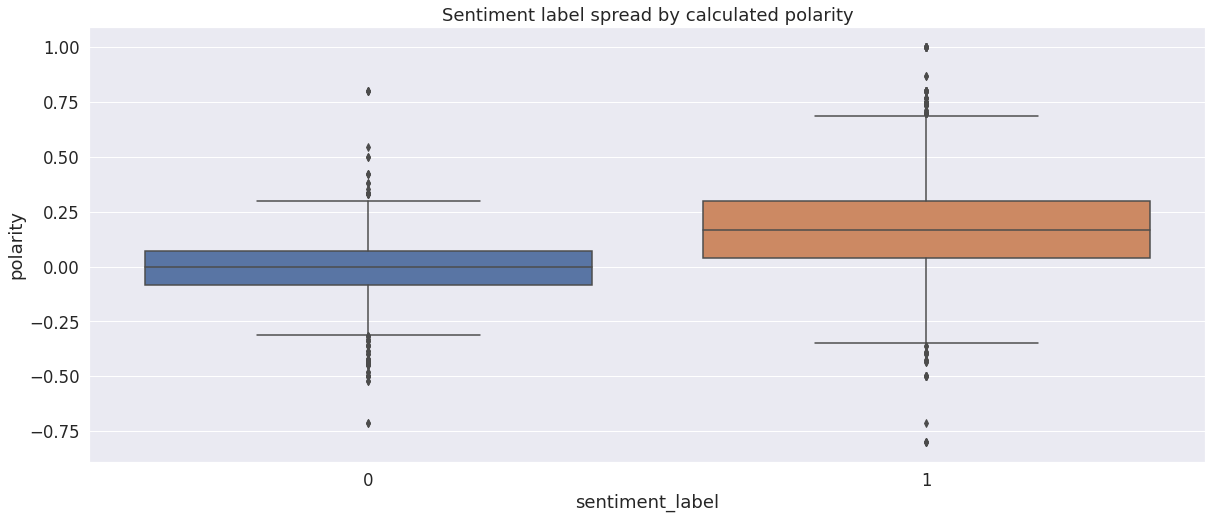

In [ ]:
from matplotlib import pyplot
import seaborn as sns

#shows the range for each rating (rating summary)
%matplotlib inline 

pyplot.figure(figsize = (20, 8))
sns.set_style('whitegrid')
sns.set(font_scale = 1.5)
sns.boxplot(x = 'sentiment_label', y = 'polarity', data = datascrape_clean)
pyplot.xlabel("sentiment_label")
pyplot.ylabel("polarity")
pyplot.title("Sentiment label spread by calculated polarity")
pyplot.show()

In [71]:
# find the calculated rating by hospital
df_hosp = datascrape_clean[['hospital','polarity']]
#a = pd.DataFrame(d, columns=['hospital', 'average'])
df_hosp = df_hosp.groupby(['hospital'])['polarity'].mean().reset_index()

In [72]:
datascrape_clean['polarity'].describe()

count    4953.000000
mean        0.129579
std         0.210707
min        -0.800000
25%         0.000000
50%         0.102083
75%         0.249675
max         1.000000
Name: polarity, dtype: float64

A quick review of these summary statistics reveals the following insights.

The min value is -0.895700, which indicates the polarity or intensity of the most negative response is strongly negative (range of sentiment polarity score is -1 to +1)
The max value is +0.988300, which indicates the polarity or intensity of the most positive response is highly positive (range of sentiment polarity score is -1 to +1)
The mean value is +0.594633 which indicates the average polarity or intensity of sentiment across all responses is in the positive territory.

#IMPLEMENTED MODEL
Next steps for this model (after selection of most appropriate) is to create a user input command that takes a hospital entered by the user and provides the generalised sentiment. In addition, using the lexicon parser, data insights can be provided to the user that shows the change in general sentiment overtime.

In [94]:
# set the rating values
conditions_hosp = [
    (df_hosp['polarity'] > -1) & (df_hosp['polarity'] <= -0.5), #Strongly Negative
    (df_hosp['polarity'] > -0.5) & (df_hosp['polarity'] < 0),   #Weakly Negative
    (df_hosp['polarity'] == 0),                             #Neutral
    (df_hosp['polarity'] > 0) & (df_hosp['polarity'] <= 0.5),   #Weakly positive
    (df_hosp['polarity'] > 0.5) & (df_hosp['polarity'] < 1)     #Strongly Positive
    ]

# create a list of the values we want to assign for each condition
values = ['Strongly Negative','Weakly Negative','Neutral','Weakly positive','Strongly Positive']


df_hosp['rating'] = np.select(conditions_hosp, values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


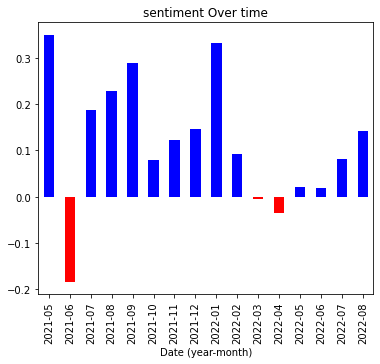

In [95]:
#put the input in to search for a hospital
dfg = datascrape_clean.loc[(datascrape_clean.hospital == "Kalgoorlie Health Campus")] 
dfg['polarity']

#sentiment over time for a hospital??
hospital_search['month_year'] = pd.to_datetime(hospital_search['datetime']).dt.to_period('M')

#generate mean of sentiment_score overtime by month
dfg = hospital_search.groupby(['month_year'])['polarity'].mean()
#create a bar plot
dfg.plot(kind='bar', title='sentiment Over time',
         xlabel='Date (year-month)', figsize=(6, 5)
       , color= ['red' if (x < 0) else 'blue' for x in dfg]
       )

